# Imports

You should not import any further functionality. If you feel this is required to complete the task, please discuss with your moderator.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# imported to keep track of compute time if you wish
import sys
np.set_printoptions(threshold=sys.maxsize)
import time

# Provided code
The below code is not necessarily complete or applicable to all tasks. Read and understand the code so that you can use wisely and adapt as required.

In [27]:
def plot_margin(X, y, clf, axs, c_value, score, margin):

    # plot the two categories
    axs.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    # set the
    axs.set_title(f"Accuracy: {score:.2f} - C: {c_value:.5f} - { 'Soft' if c_value < 1 else 'Hard'} - Margin Width: {margin:.2f}")

    #print(f"Coefficients: {clf.coef_}")
    #print(f"Intercept: {clf.intercept_}")

    xlim = axs.get_xlim()
    ylim = axs.get_ylim()

    xx, yy, YY, XX, xy, Z = calculate_xx_yy_YY_XX_xy_Z(xlim, ylim, clf)

    # plot decision boundary and margins
    axs.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # plot support vectors
    axs.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')

In [28]:
def calculate_xx_yy_YY_XX_xy_Z(xlim, ylim, clf) :
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    Z = clf.decision_function(xy).reshape(XX.shape)

    return xx, yy, YY, XX, xy, Z

To compare the SVM with a NN:

In [29]:
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve

# set the value of n_jobs
# get n_jobs value
# import joblib
# n_jobs = joblib.cpu_count()
# print(f"Number of available CPU cores: {n_jobs}")
n_jobs_local = -1

In [30]:
def plot_decisions(X, y, model, title):
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1

    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # make predictions for the grid
    yhat = model.predict(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)

    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')

    # create scatter plot for samples from each class
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1])

    plt.title(title)
    plt.show()

In [31]:
def plot_decisions_svm_mlp(X, y, model_svm, model_mlp, title) :
    # Create a mesh to plot the decision boundary
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Plot the SVM decision boundary
    Z_svm = model_svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z_svm = Z_svm.reshape(xx.shape)

    contour_svm = plt.contourf(xx, yy, Z_svm, alpha=0.3, cmap='coolwarm')
    plt.contour(xx, yy, Z_svm, colors='r', linewidths=0.5)
    plt.clabel(contour_svm, inline=True, fontsize=8, fmt='SVM')

    # Plot the MLPClassifier decision boundary
    Z_mlp = model_mlp.predict(np.c_[xx.ravel(), yy.ravel()])
    Z_mlp = Z_mlp.reshape(xx.shape)

    contour_mlp = plt.contourf(xx, yy, Z_mlp, alpha=0.3, cmap='coolwarm')
    plt.contour(xx, yy, Z_mlp, colors='y', linewidths=0.5)
    plt.clabel(contour_mlp, inline=True, fontsize=8, fmt='MLP')

    # create scatter plot for samples from each class
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1])

    # Plot the original data points
    plt.title(title)
    plt.show()

In [32]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_errors = 1- train_scores
    test_errors = 1-test_scores
    
    train_errors_mean = np.mean(train_errors, axis=1)
    train_errors_std = np.std(train_errors, axis=1)
    test_errors_mean = np.mean(test_errors, axis=1)
    test_errors_std = np.std(test_errors, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Test error")

    
    plt.legend(loc="best")
    return plt

In [33]:
class MLPWrapper(BaseEstimator, ClassifierMixin):
    
    def __init__(self, layer1=10, layer2=10, activation="relu"):
        self.layer1 = layer1
        self.layer2 = layer2
        self.activation = activation

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2, self.layer2], # 2 HIDDEN LAYERS
            #hidden_layer_sizes=[(layer1, layer2) for layer1 in range(1, 100) for layer2 in range(1, 100)],
            #hidden_layer_sizes=[Integer(1, 100), Integer(1, 100), Integer(1, 100), Integer(1, 100)], # 4 nodes
            activation = Categorical(['identity', 'logistic', 'tanh', 'relu']),
            max_iter = 1000,
            learning_rate= 'adaptive', # I added this extra parameter
            early_stopping =True       # I added this extra as well - STOP ONCE HAVE A GOOD OPTION
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

This wrapper is required in below BayesSearchCV for a neural network to combine the two layer arguments (or more if you wish to experiment with more than two layers) into the single hidden_layer_sizes hyper-parameter.

In [34]:
# Example use of BayesSearchCV to search a large search space whilst keeping compute requirements in check

optSVM1_lin = BayesSearchCV(
    svm.SVC(),
    {
        'C': Real(1e-3, 1e+3, prior='log-uniform'),
        'kernel': Categorical(['linear']),
    },
    n_iter=40,
)

In [35]:
# Example use of BayesSearchCV with the MLPWrapper to vary the layer sizes

optNN1 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 100),
        'layer2': Integer(1, 100)
    },
    n_iter=40,
)

In [36]:
def read_data_file(filename):
    """ Read training data from file. """

    data = np.genfromtxt(filename, delimiter=',', skip_header=1)

    return data

In [37]:
def extract_features(data) :
    """ Extract X and y from the data .  """

    X = data[:, :-1] # give me all thew columns except the last one
    y = data[:, -1]  # give me the last column

    return X, y

In [38]:
def calculate_accuracy (y_test, y_pred) :
    """ This is a poor man version of the panda library call  """

    return np.mean(y_test == y_pred)

# Solutions

In [39]:
def train_score_svm_plot(X, y, X_train, y_train, c_value, axs, kernel_value) :
    """ Train SVM classifier on training data .  """

    clf = svm.SVC(kernel=kernel_value, C=c_value)
    clf.fit(X_train, y_train)

    # get the score
    score = clf.score(X_train, y_train)

    # calculate the margin
    margin = -1
    if kernel_value == 'linear':
        margin = 2 / np.linalg.norm(clf.coef_[0])

    plot_margin(X, y, clf, axs, c_value, score, margin)

    return score

## Task 1
Perform classification on dataset_1_train.csv using an SVM with linear kernel and experiment with the C-parameter to find the widest margin solution with a hard margin and a soft margin.

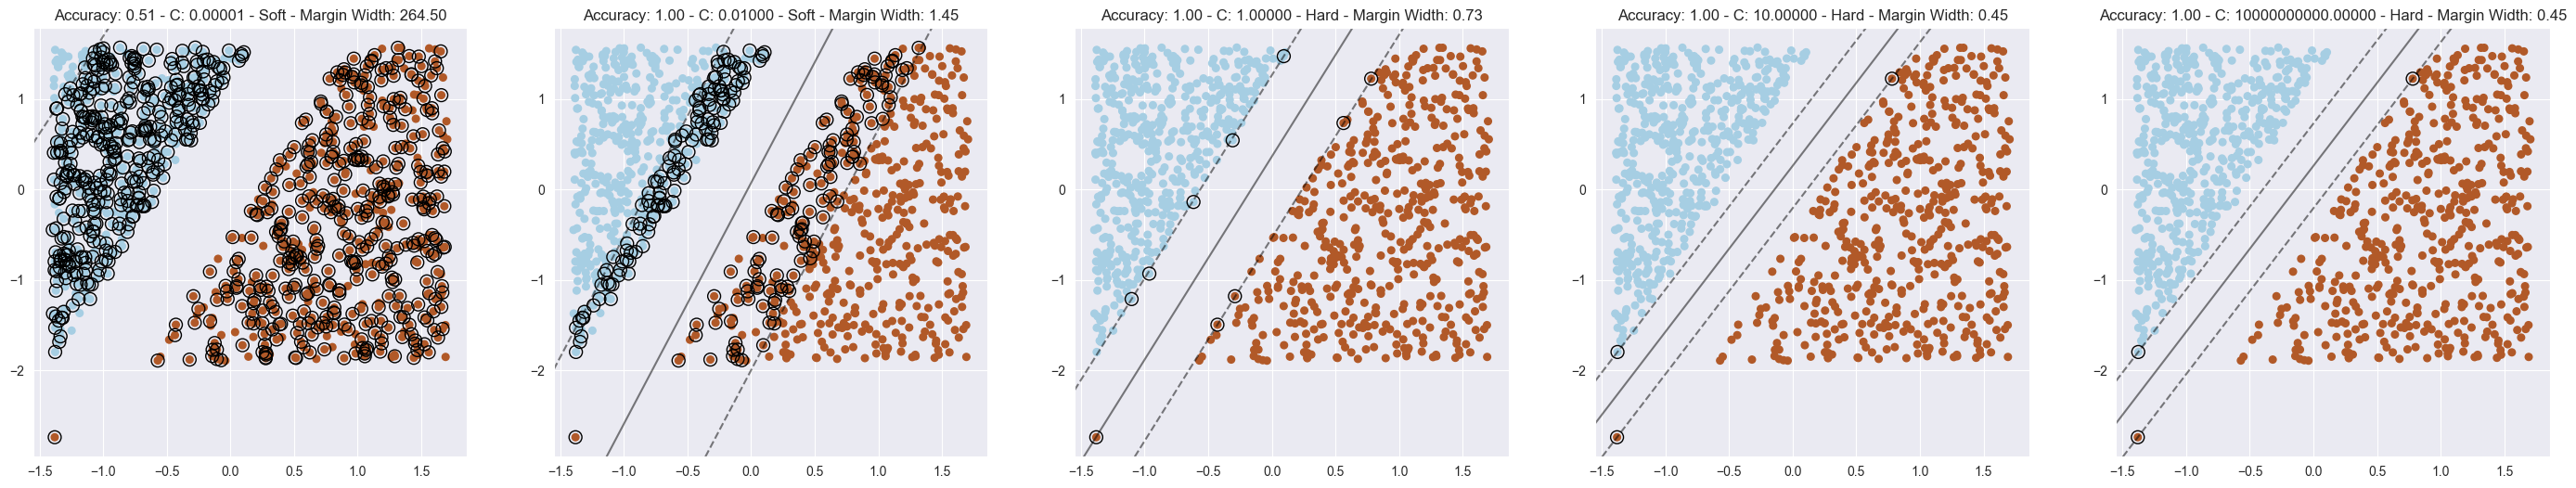

In [40]:
data = read_data_file("dataset_1_train.csv")
X, y = extract_features(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 1e10  - hard margin (large C)
# 1, 10 - soft margin (small C)
C = [1e-5, 1e-2, 1, 10, 1e10]

# setup the canvas for C number of graphs
fig, axs = plt.subplots(nrows=1, ncols=len(C), figsize=(35, 6))

for index, c_value in enumerate(C):
    train_score_svm_plot(X, y, X_train, y_train, c_value, axs[index], 'linear')


In [41]:
# run the validation to see which C value is the best

param_grid = {'C': [1e-5, 1e-2, 1, 10, 1e10]}
grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=10)
grid_search.fit(X_train, y_train)

print("Best C value:", grid_search.best_params_['C'])

Best C value: 0.01


In [42]:
# I wanted to see how other Kernels behave !! - nothing to do with the task

#data = read_data_file("dataset_1_train.csv")
#X, y = extract_features(data)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 1e10  - hard margin (large C)
# 1, 10 - soft margin (small C)
#C = [1e-5, 1e-2, 1, 10, 1e10]

# setup the canvas for C number of graphs
#fig, axs = plt.subplots(nrows=1, ncols=len(C), figsize=(35, 6))

#for index, c_value in enumerate(C):
#    train_score_svm_plot(X, y, X_train, y_train, c_value, axs[index], 'sigmoid')

## Answers to questions

# Task 2
- 1) Explore the provided data sets using Support Vector Machines and choose suitable kernels and hyper-parameters. Use the _train datasets to train your model after which you can test the generalisation of the resulting model using the _test datasets.
- 2) Perform the same exploration for a Neural Network classifier and think carefully about the hyperparameters you wish to optimise. Also here, the goal is to explore the various hyper-parameters available in neural networks.
- 3) Investigate (think back of previous E-tivities and look at the provided functions) how the complexity of the winning SVM and neural network compare.

In [43]:
def fit_predict_dataset_3(X3, y3, opt, cv_value, title) :
    data_3_test = read_data_file("dataset_3_test.csv")
    X3_test, y3_test = extract_features(data_3_test)

    opt.fit(X3, y3)

    print("Best parameters found: ", opt.best_params_)
    print("Best cross-validation score: ", opt.best_score_)
    print(f"Test Accuracy: {opt.score(X3_test, y3_test):.2f}")

    # calculate all the fold values for each fold - want to see the values used
    #cv_scores = cross_val_score(opt, X3, y3, cv=cv_value)
    #print(f'* Cross-validation scores: {cv_scores}')
    #print(f'* Mean cross-validation score: {cv_scores.mean():.2f}')

    # plot graphs
    plot_decisions(X3, y3, opt, title + " - Decision Boundary")
    plot_learning_curve(opt.best_estimator_, title + " - Learning curve", np.concatenate((X3, X3_test)), np.concatenate((y3, y3_test)))


In [44]:
def read_extract_features_train_dataset2():
    data_2 = read_data_file("dataset_2_train.csv")
    X2, y2 = extract_features(data_2)

    return X2, y2

In [45]:
def read_extract_features_train_dataset3():
    data_3 = read_data_file("dataset_3_train.csv")
    X3, y3 = extract_features(data_3)

    return X3, y3

In [46]:
def read_extract_features_test_dataset2():
    data_2_test = read_data_file("dataset_2_test.csv")
    X2_test, y2_test = extract_features(data_2_test)

    return X2_test, y2_test

In [47]:
def read_extract_features_test_dataset3():
    data_3_test = read_data_file("dataset_3_test.csv")
    X3_test, y3_test = extract_features(data_3_test)

    return X3_test, y3_test

In [48]:
def fit_predict_dataset_2(X2, y2, opt, cv_value, title) :
    X2_test, y2_test = read_extract_features_test_dataset2()

    opt.fit(X2, y2)

    print("Best parameters found: ", opt.best_params_)
    print("Best cross-validation score: ", opt.best_score_)
    print(f"Test Accuracy: {opt.score(X2_test, y2_test):.2f}")

    # calculate all the fold values for each fold - want to see the values used
    #cv_scores = cross_val_score(opt, X2, y2, cv=cv_value)
    #print(f'* Cross-validation scores: {cv_scores}')
    #print(f'* Mean cross-validation score: {cv_scores.mean():.2f}')

    # plot graphs
    plot_decisions(X2, y2, opt, title + " - Decision Boundary")
    plot_learning_curve(opt.best_estimator_, title + " - Learning curve", np.concatenate((X2, X2_test)), np.concatenate((y2, y2_test)))

In [49]:
# svc experiment - search space used for dataset 2 / 3

model = svm.SVC()
search_space = {
        'C': (1e-5, 1e+5, 'log-uniform'),
        'gamma': (1e-6, 1e+6, 'log-uniform'),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4] # recommended values
}

In [ ]:
# SVC DATASET 2
#  execution time: 47 min

# verbose=1 gives you logs - not interested in the spam for now :)
# n_jobs - "joblib.cpu_count()"
# random_state - meaning of life
# cv - 5  (number of folds)
# n_iter (was started with 40 and then using "plot_convergence(opt_2.optimizer_results_[0])" was pushed down to 29, it was taking way too long)
# n_points was used to speed up things , left it at 3
# scoring - how to validate the result after each fold

opt_2 = BayesSearchCV(model, search_space, n_points=3, n_iter=11, verbose=0, cv=5, n_jobs=n_jobs_local, random_state=42, scoring='accuracy')

X2, y2 = read_extract_features_train_dataset2()

fit_predict_dataset_2(X2, y2, opt_2, cv_value= 5, title="BayesSearchCV + SVM - dataset2")
print(f"Number of support vectors (Model Complexity): {len(opt_2.best_estimator_.support_)}")

In [ ]:
#from skopt.plots import plot_convergence, plot_objective

# Plot the convergence of the search process
#plot_convergence(opt_2.optimizer_results_[0])

# Plot the objective function
#plot_objective(opt_2.optimizer_results_[0])

In [ ]:
# get n_jobs value
# import joblib
# n_jobs = joblib.cpu_count()
# print(f"Number of available CPU cores: {n_jobs}")

In [ ]:
# SVC DATASET 3
#  execution time: 25 min (5 min)

# verbose=1 gives you logs - not interested in the spam for now :)
# n_jobs - "joblib.cpu_count()"
# random_state - meaning of life
# cv - 5  (number of folds)
# n_iter (was started with 40 and then using "plot_convergence(opt_2.optimizer_results_[0])" was pushed down to 29, it was taking way too long)
# n_points was used to speed up things , left it at 3
# scoring - how to validate the result after each fold

opt_3 = BayesSearchCV(model, search_space, n_iter=34,  n_points=3, verbose=0, cv=5, n_jobs=n_jobs_local, random_state=42, scoring='accuracy')

X3, y3 = read_extract_features_train_dataset3()

fit_predict_dataset_3(X3, y3, opt_3, cv_value= 5, title="BayesSearchCV + SVM - dataset3")
print(f"Number of support vectors (Model Complexity): {len(opt_3.best_estimator_.support_vectors_)}")

In [ ]:
#from skopt.plots import plot_convergence, plot_objective

# Plot the convergence of the search process
#plot_convergence(opt_3.optimizer_results_[0])

# Plot the objective function
#plot_objective(opt_3.optimizer_results_[0])

In [ ]:
# get the dataset 2 features
X2, y2 = read_extract_features_train_dataset2()

n_features = X2.shape[1]

search_spaces = {
    'hidden_layer_sizes' : (n_features, n_features*2),
    'activation': Categorical(['identity', 'logistic', 'tanh', 'relu']),
    'batch_size': Integer(16, 128),
    'alpha': Real(1e-6, 1e+2, prior='log-uniform'),
    'solver': Categorical(['lbfgs', 'sgd', 'adam']),
}

# Create the modified MLPWrapper model
# max_iter = 10000 - for one of the combinations was getting a termination error , so increased it to 10k
mlp_wrapper = MLPClassifier(max_iter = 10000, early_stopping =True, learning_rate="adaptive")

# Declare search strategy
optNN1_2 = BayesSearchCV(estimator=mlp_wrapper, search_spaces=search_spaces, n_points=4, n_iter=6, cv=5, n_jobs=n_jobs_local, random_state=42, scoring='accuracy')

fit_predict_dataset_2(X2, y2, optNN1_2, cv_value=5, title="BayesSearchCV + NN - dataset2")

# model complexity
print(f"Num layers (excluding input layer): {len(optNN1_2.best_estimator_.coefs_)}")

for i, coef in enumerate(optNN1_2.best_estimator_.coefs_):
    print(f"Shape of weight matrix between layer {i} and layer {i+1}: {coef.shape}")

optNN1_2_total_params = sum(coef.size for coef in optNN1_2.best_estimator_.coefs_) + sum(intercept.size for intercept in optNN1_2.best_estimator_.intercepts_)
print(f"Total num of parameters: {optNN1_2_total_params}")


In [ ]:
#from skopt.plots import plot_convergence, plot_objective, plot_histogram
import seaborn as sns

# Plot the convergence of the search process
#plot_convergence(optNN1_2.optimizer_results_[0])

# Plot the objective function
#plot_objective(optNN1_2.optimizer_results_[0])

#fig, ax = plt.subplots(1, 5, figsize = (10, 5))
#plt.subplots_adjust(wspace=0.4)
#plot_histogram(optNN1_2.optimizer_results_[0], 0, ax = ax[0])
#plot_histogram(optNN1_2.optimizer_results_[0], 1, ax = ax[1])
#plot_histogram(optNN1_2.optimizer_results_[0], 2, ax = ax[2])
#plot_histogram(optNN1_2.optimizer_results_[0], 3, ax = ax[3])
#plot_histogram(optNN1_2.optimizer_results_[0], 4, ax = ax[4])

#plt.figure()
#sns.lineplot(x = range(0, len(optNN1_2.optimizer_results_[0]['func_vals'])), y = optNN1_2.optimizer_results_[0]['func_vals'])
#plt.xlabel('Iteration')
#plt.ylabel('Cross-validated score')
#plt.show();

In [ ]:
X3, y3 = read_extract_features_train_dataset3()

search_spaces = {
    'hidden_layer_sizes': Categorical([100, 50, 25]),
    'activation': Categorical(['identity', 'logistic', 'tanh', 'relu']),
    'batch_size': Integer(16, 128),
    'alpha': Real(1e-6, 1e+2, prior='log-uniform'),
    'solver': Categorical(['lbfgs', 'sgd', 'adam'])
}

# Create the modified MLPWrapper model
mlp_wrapper = MLPClassifier(max_iter = 1000, early_stopping =True, learning_rate="adaptive")

# Declare search strategy
optNN1_3 = BayesSearchCV(estimator=mlp_wrapper, search_spaces=search_spaces, n_points=4, n_iter=8, cv=5, n_jobs=n_jobs_local, random_state=42, scoring='accuracy')

fit_predict_dataset_3(X3, y3, optNN1_3, cv_value=5, title="BayesSearchCV + NN - dataset3")

# model complexity
print(f"Num layers (excluding input layer): {len(optNN1_3.best_estimator_.coefs_)}")

for i, coef in enumerate(optNN1_3.best_estimator_.coefs_):
    print(f"Shape of weight matrix between layer {i} and layer {i+1}: {coef.shape}")

optNN1_3_total_params = sum(coef.size for coef in optNN1_3.best_estimator_.coefs_) + sum(intercept.size for intercept in optNN1_3.best_estimator_.intercepts_)
print(f"Total num of parameters: {optNN1_3_total_params}")

In [ ]:
#from skopt.plots import plot_convergence, plot_objective, plot_histogram
import seaborn as sns

# Plot the convergence of the search process
#plot_convergence(optNN1_3.optimizer_results_[0])

# Plot the objective function
#plot_objective(optNN1_3.optimizer_results_[0])

#fig, ax = plt.subplots(1, 3, figsize = (10, 3))
#plt.subplots_adjust(wspace=0.4)
#plot_histogram(optNN1_3.optimizer_results_[0], 0, ax = ax[0])
#plot_histogram(optNN1_3.optimizer_results_[0], 1, ax = ax[1])
#plot_histogram(optNN1_3.optimizer_results_[0], 2, ax = ax[2])

#plt.figure()
#sns.lineplot(x = range(0, len(optNN1_3.optimizer_results_[0]['func_vals'])), y = optNN1_3.optimizer_results_[0]['func_vals'])
#plt.xlabel('Iteration')
#plt.ylabel('Cross-validated score')
#plt.show();

In [ ]:
X2_plot, y2_plot = read_extract_features_test_dataset2()

# red line svm
# yellow line mlp
plot_decisions_svm_mlp(X2_plot, y2_plot, opt_2, optNN1_2, 'SVM and MLPClassifier Decision Boundaries dataset 2')

In [ ]:
X3_plot, y3_plot = read_extract_features_test_dataset3()

# red line svm
# yellow line mlp
plot_decisions_svm_mlp(X3_plot, y3_plot, opt_3, optNN1_3, 'SVM and MLPClassifier Decision Boundaries dataset 3')

## Answers to Questions


# Reflection

1) For Task 1 the value of "C = [1e-5, 1e-2, 1, 10, 1e10]" , was picked at random and the idea was to pick hard and soft margins. The test size of 20 % was picked as a standard value. I added some code to calculate the margin width and a flag to indicate if a margin is soft / hard, to make it easy to identify the values. Also added a code to detect the best C value for Task 1 and the value for model complexity from the support vector list.
3) For Task 2 the 'search_space' values and pairs got at random , based on best value recommendations, ie "degree" the recommended data range is 2 to 4 or whatever list was provided in the documentation of the property.
4) I did not use the provided wrappers , as I wanted a clean separation between the model and BayesSearchCV and the ability to config each component separately.
5) The values for "n_iter" was picked by running the code for 40 and then executing the call "plot_convergence from skopt.plots", the code was commented out , but that is how I came about picking the number
6) The value for "random_state" as standard is 42 (meaning of life)
7) The value of "cv" is bt default 5 , I played with 10 and saw no difference so went back to 5
8) The value of "n_points" I left it at 3 , played around it, and it added no difference.
9) The value of "hidden_layer_sizes" - in dataset 2 I went for the form of  "(n_features, n_features*2)" as I wanted to build the value from the input , for dataset 3 I went for the form of "Categorical([100, 50, 25])", to see if it would do any better.
10) I set early_stopping="true" and learning_rate="adaptive" from past eTivities results